In [25]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np

from wavhandler import *
from utils import *
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
sn.set()

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [26]:
df_mosquitos = pd.read_csv(TEMP_DATADIR+'mosquitos.csv', delimiter=';')

In [27]:
#bi_classes = ['LG_drosophila_10_09', 'LG_zapr_26_09']
#target_names = all_6
DATADIR = '/home/kalfasyan/data/insects/Wingbeats/'
target_names = os.listdir(DATADIR)

X_names, y = get_data(filedir= DATADIR,
                      target_names=target_names, nr_signals=np.inf, only_names=True)

100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


In [28]:
for i,t in enumerate(target_names):
    print(i,t)
print(target_names)

0 An. arabiensis
1 Ae. aegypti
2 An. gambiae
3 C. pipiens
4 Ae. albopictus
5 C. quinquefasciatus
['An. arabiensis', 'Ae. aegypti', 'An. gambiae', 'C. pipiens', 'Ae. albopictus', 'C. quinquefasciatus']


# Creating a dataframe of PSDs for all mosquito classes

In [29]:
%%time
X = make_df_parallel(names=X_names, setting='psd')
df_concat = pd.DataFrame(X.T)
df_concat['label'] = y

# print(df_concat.label.value_counts())
# df_concat = df_concat[df_concat.label.isin([0,1])]
# print(df_concat.label.value_counts())

CPU times: user 48.7 s, sys: 1.49 s, total: 50.2 s
Wall time: 1min 28s


# Loading the general dataframe (with custom features)

In [ ]:
# df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')
df_mosquitos.drop(['names','pathlen','fnamelen','temp','humd'], axis=1, inplace=True)
df_mosquitos.set_index('fname', inplace=True)
labelarray_mosq = df_mosquitos.label.values
print(df_mosquitos.shape)
df_mosquitos.tail(10)

In [ ]:
# df = pd.merge(df_mosquitos, df_concat, left_index=True, right_index=True)
# df.drop(['label_x','label_y'], axis=1, inplace=True)
# # df.to_pickle('./data/big_df.pkl')
# print(df.shape)
# df.head()

## Selecting which dataframe to use

In [30]:
df = df_concat#df_mosquitos.iloc[:,:-1]
cols = df.columns.tolist()
labels = df.label
classes = np.unique(labels)
#df.label.value_counts()

In [31]:
pd.Series(labels).value_counts()

1    85553
5    74599
2    49471
3    30415
4    20231
0    19297
Name: label, dtype: int64

# Training a classifier

In [32]:
# X, y = get_data(target_names=target_names, nr_signals=20000, only_names=False)
# X = transform_data(X)

In [33]:
from sklearn.neural_network import MLPClassifier

In [34]:
X, y = shuffle(df.iloc[:,:-1].values, labels, random_state=3)

from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=0)
ros.fit(X,y)
X, y = ros.fit_resample(X,y)
print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier =  MLPClassifier(hidden_layer_sizes=(15,), 
                            alpha=1, 
                            learning_rate='adaptive',
                            verbose=True,
                            random_state=42)
#xgboost.XGBClassifier(n_estimators=650, learning_rate=0.2, n_jobs=-1)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac = accuracy_score(y_test, y_pred)
#cv_ac = cross_val_score(classifier, X, y, cv=3, scoring='accuracy')
print("Name: %s, ac: %f" % ('model', ac))
#print("Name: %s, cv_ac: %f" % ('XGBoost', np.mean(cv_ac)))

After undersampling: 
5    19297
4    19297
3    19297
2    19297
1    19297
0    19297
Name: 0, dtype: int64

Iteration 1, loss = 1.53080964
Iteration 2, loss = 1.30392707
Iteration 3, loss = 1.28683228
Iteration 4, loss = 1.28208516
Iteration 5, loss = 1.27981610
Iteration 6, loss = 1.27864805
Iteration 7, loss = 1.27788791
Iteration 8, loss = 1.27745553
Iteration 9, loss = 1.27697732
Iteration 10, loss = 1.27669585
Iteration 11, loss = 1.27653267
Iteration 12, loss = 1.27635014
Iteration 13, loss = 1.27618092
Iteration 14, loss = 1.27616860
Iteration 15, loss = 1.27607866
Iteration 16, loss = 1.27603941
Iteration 17, loss = 1.27584263
Iteration 18, loss = 1.27591475
Iteration 19, loss = 1.27588780
Iteration 20, loss = 1.27587471
Iteration 21, loss = 1.27580237
Iteration 22, loss = 1.27582099
Iteration 23, loss = 1.27577600
Iteration 24, loss = 1.27581435
Iteration 25, loss = 1.27586084
Iteration 26, loss = 1.27579820
Iteration 27, loss = 1.27576536
Iteration 28, loss = 1.27586953
Tr

In [51]:
print('done')

done


## Feature importance

In [52]:
feature_importances = pd.DataFrame(classifier.feature_importances_,
                                    index = df.iloc[:,:-1].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

,importance
4,0.019563
8,0.018412
5,0.014730
36,0.014269
0,0.014039
2,0.013119
93,0.012658
12,0.012658
1,0.012428
27,0.012198


### Saving the model

In [ ]:
import pickle

pickle.dump(classifier, open("./data/pima.pickle.dat", "wb"))
pd.Series(df.index).to_csv('./data/pima_idx_used.csv')

# loaded_model = pickle.load(open("pima.pickle.dat", "rb"))

In [ ]:
pd.DataFrame(X).to_csv('./data/unsupervised/mosquitos_test.csv')

# Confusion matrix

In [53]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[913, 176],
       [239, 887]])

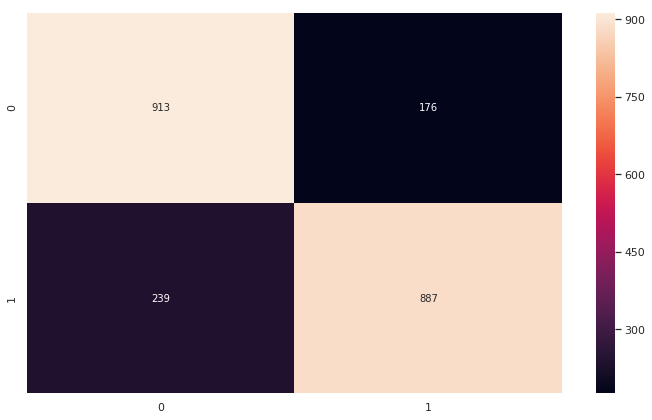

In [56]:
# Making a dataframe of the confusion matrix to plot it
df_cm = pd.DataFrame(cm, index=[i for i in classes], 
                    columns=[i for i in classes])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True, fmt='g')

plt.show()

## Distance Matrix

In [57]:
sub = np.concatenate((X, y.reshape(-1,1)), axis=1)
sub = pd.DataFrame(sub)
sub.sort_values(by=sub.iloc[:,-1].name, inplace=True)

In [58]:
sub.dropna(how='any', axis=0, inplace=True)


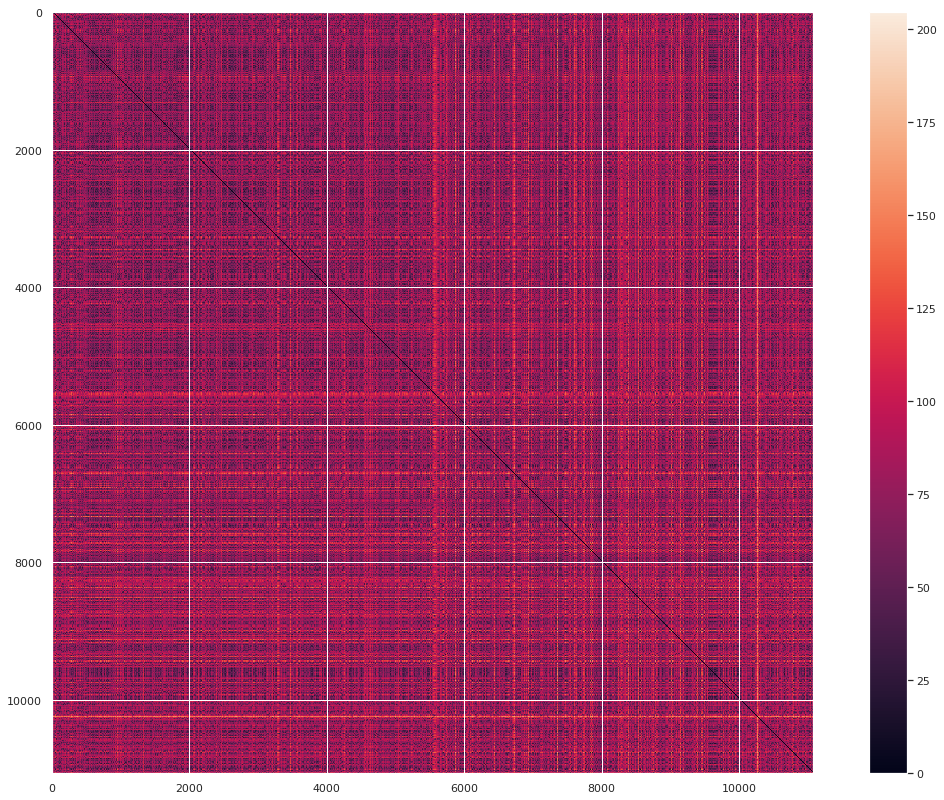

In [59]:
from scipy.spatial.distance import pdist, squareform
D = squareform(pdist(sub.values[:,:-1], metric='euclidean'))
#‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, 
#‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, 
#‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

plt.figure(figsize=(20,14))
plt.imshow(D)
plt.colorbar()

# Time warping

In [ ]:
def find_median_signal(D=None):
    a = np.nanmedian(D, axis=0)
    minval = np.argmin(a[np.nonzero(a)])
    return minval # index - argmin

In [ ]:
X = sub.values[:,:-1]

In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

xx = X[50,:]
yy = X[13,:]

distance, path = fastdtw(xx, yy, dist=euclidean)
print(distance)

xx_idx = np.array([path[i][0] for i in range(len(path))])
yy_idx = np.array([path[i][1] for i in range(len(path))])

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(xx, c='r')
plt.plot(yy, c='y')
plt.legend(('xx','yy'))
#plt.ylim(0,0.15)

plt.subplot(2,2,2)
plt.plot(xx[xx_idx], c='b')
plt.plot(yy[yy_idx], c='c')
plt.legend(('xx_new','yy_new'))
#plt.ylim(0,0.15)

plt.subplot(2,2,3)
plt.plot(xx, c='r')
plt.plot(xx[xx_idx], c='b')
plt.legend(('xx','xx_new'))
#plt.ylim(0,0.15)

plt.subplot(2,2,4)
plt.plot(yy, c='y')
plt.plot(yy[yy_idx], c='c')
plt.legend(('yy','yy_new'))
#plt.ylim(0,0.15)

In [ ]:
median_signal_idx = find_median_signal(D=X.astype(float))
median_signal = X[median_signal_idx,:]
plt.plot(median_signal)

In [ ]:
#X.shape

D_dtw = np.zeros((600,600))

def warp_with_median_signal(xx, median_signal, distance=euclidean):
    _, path = fastdtw(xx, median_signal, dist=distance)
    
    idx = np.array([path[i][0] for i in range(len(path))])
    sig = xx[idx]
    
    return sig[:128]

In [ ]:
sig = X[10,:]
plt.subplot(1,2,1)
plt.plot(warp_with_median_signal(sig, median_signal, distance=euclidean))
#plt.xlim(0,2500)

plt.subplot(1,2,2)
plt.plot(sig)
#plt.xlim(0,2500)

In [ ]:
from tqdm import tqdm

XX = []
for i in tqdm(range(X.shape[0])):
    XX.append(warp_with_median_signal(X[i,:], median_signal, distance=euclidean))

In [ ]:
len(XX[2])

In [ ]:
XX = np.vstack(XX)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

X, y = shuffle(XX, y, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier = xgboost.XGBClassifier(n_estimators=300, n_jobs=-1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost', ac))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm